In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importation des outils du package particles
from particles import state_space_models as ssm
from particles import distributions as dists
from particles import smc_samplers
from particles import resampling

## Realized Stochastic Volatility Model

In [155]:
class RSVModel(ssm.StateSpaceModel):
    def PX0(self):  # Distribution initiale de x_0
        return dists.Normal(loc=self.mu, scale=np.sqrt(self.sigma_eta2 / (1 - self.phi**2)))

    def PX(self, t, xp):  
        return dists.Normal(loc=self.mu + self.phi * (xp - self.mu), scale=np.sqrt(self.sigma_eta2))
        # dists.Normal permet de sommer loc avec un bruit scale qui suit une loi normale centrée et d'écart type sigma_eta2.

    def PY(self, t, xp, x):
        return dists.IndepProd(
            dists.Normal(loc=0, scale=np.exp(x / 2)),           # Observation y1_t
            dists.Normal(loc=x + self.xi, scale=np.sqrt(self.sigma_u2))  # Observation y2_t
    )

## S&P 500 importation 

In [156]:
import yfinance as yf

In [128]:
# Téléchargement des données
sp500 = yf.download('^GSPC', start='2007-12-31', end='2016-12-30')

[*********************100%***********************]  1 of 1 completed


In [129]:
sp500 = sp500.reset_index()

In [130]:
# Filtrage des colonnes nécessaires (data, rendements et volatilité réalisée)

# Date
sp500['Date'] = pd.to_datetime(sp500['Date'])

# Calcul du rendement journalier logarithmique ln(Pt/Pt-1)
sp500['log_returns'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
sp500['log_realized_volatility'] = np.log(np.abs(sp500['log_returns']) + 1e-6)

In [131]:
sp500 = sp500[['Date', 'log_returns', 'log_realized_volatility']]
sp500 = sp500.dropna()

## S&P 500 visualisation des données

In [132]:
sp500

Price,Date,log_returns,log_realized_volatility
Ticker,,,
1,2008-01-02,-0.014543,-4.230571
2,2008-01-03,0.000000,-13.815511
3,2008-01-04,-0.024858,-3.694537
4,2008-01-07,0.003218,-5.738661
5,2008-01-08,-0.018523,-3.988701
...,...,...,...
2262,2016-12-22,-0.001865,-6.284113
2263,2016-12-23,0.001251,-6.683067
2264,2016-12-27,0.002246,-6.098227


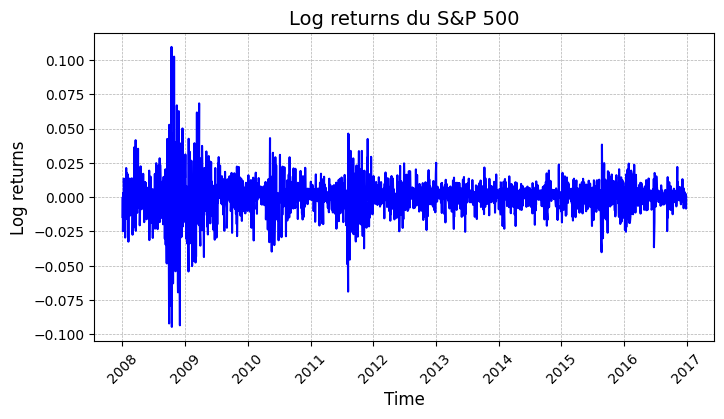

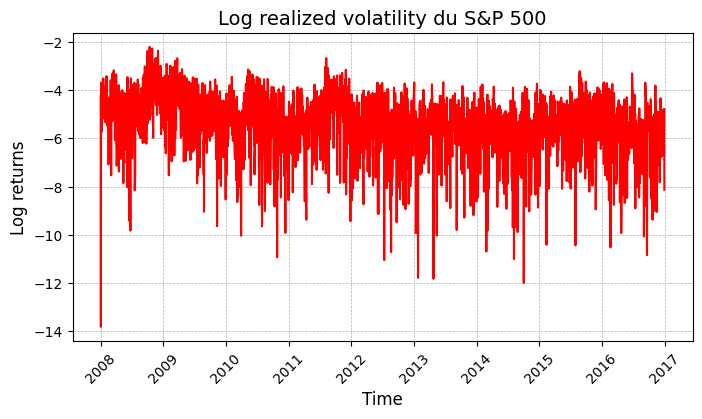

In [157]:
#filtered_data = sp500[(sp500['Date'] >= '2003-01-01') & (sp500['Date'] <= '2003-12-31')]

plt.figure(figsize=(8, 4))  
plt.plot(sp500['Date'], sp500['log_returns'], color='blue', linewidth=1.5)
plt.title('Log returns du S&P 500', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Log returns', fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize = (8,4))
plt.plot(sp500['Date'], sp500['log_realized_volatility'], color='red', linewidth=1.5)
plt.title('Log realized volatility du S&P 500', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Log returns', fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.show()

## Définition des paramètres du RSV

In [158]:
# Paramètres initiaux
params = {
    'mu': 0,                # Moyenne de la volatilité
    'phi': 0.98,            # Auto-corrélation
    'sigma_eta2': 0.02,     # Variance du bruit d'état
    'xi': 0,                # Décalage constant
    'sigma_u2': 0.01        # Variance de l'erreur de mesure
}

# Modèle RSV
rsv_model = RSVModel(mu=params['mu'], 
                     phi=params['phi'], 
                     sigma_eta2=params['sigma_eta2'], 
                     xi=params['xi'], 
                     sigma_u2=params['sigma_u2'])

In [159]:
from particles.core import SMC
from particles.resampling import multinomial

## Application du filtre

In [167]:
# Nombre de particules
N = 100

# Données observées : (log-rendements, log-volatilité réalisée)
observed_data = sp500[['log_returns', 'log_realized_volatility']].dropna().to_numpy()

# Définir le modèle Bootstrap
fk_model = ssm.Bootstrap(ssm=rsv_model, data=observed_data)

# Initialisation du filtre de particules avec SMC
pf = SMC(fk=fk_model, N=N)

# Exécuter le filtre
next(pf)  # une etape
pf.run()  # run complet

# Résultats
log_marginal_likelihood = pf.logLt  # Log-vraisemblance marginale
particles_states = [p.mean() for p in pf.X]  # Moyenne des particules


Text(0, 0.5, 'ESS')

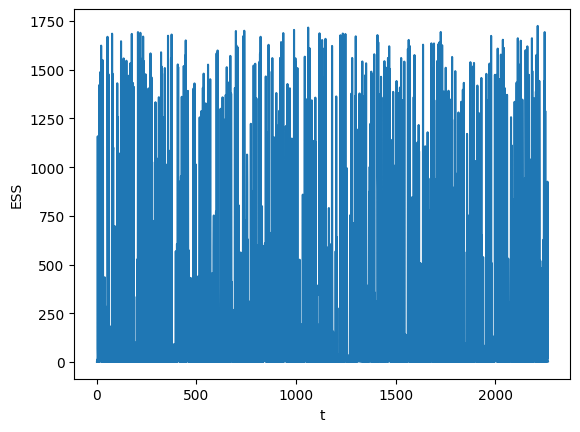

In [162]:
plt.plot(pf.summaries.ESSs)
plt.xlabel('t')
plt.ylabel('ESS')

Text(0, 0.5, 'log-likelihood')

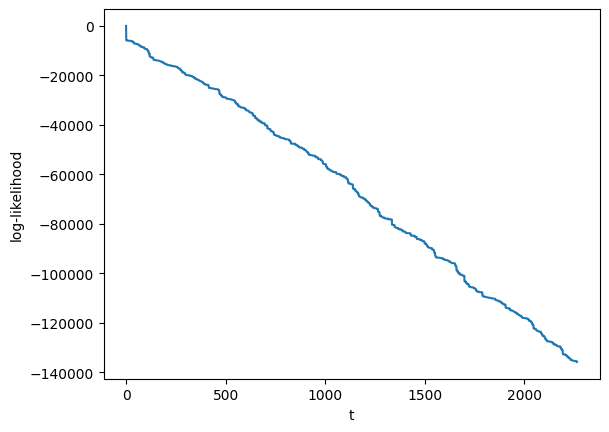

In [163]:
plt.plot(pf.summaries.logLts)
plt.xlabel('t')
plt.ylabel('log-likelihood')

## Premier test sans les données ni le filtrage ci-dessus pour les images

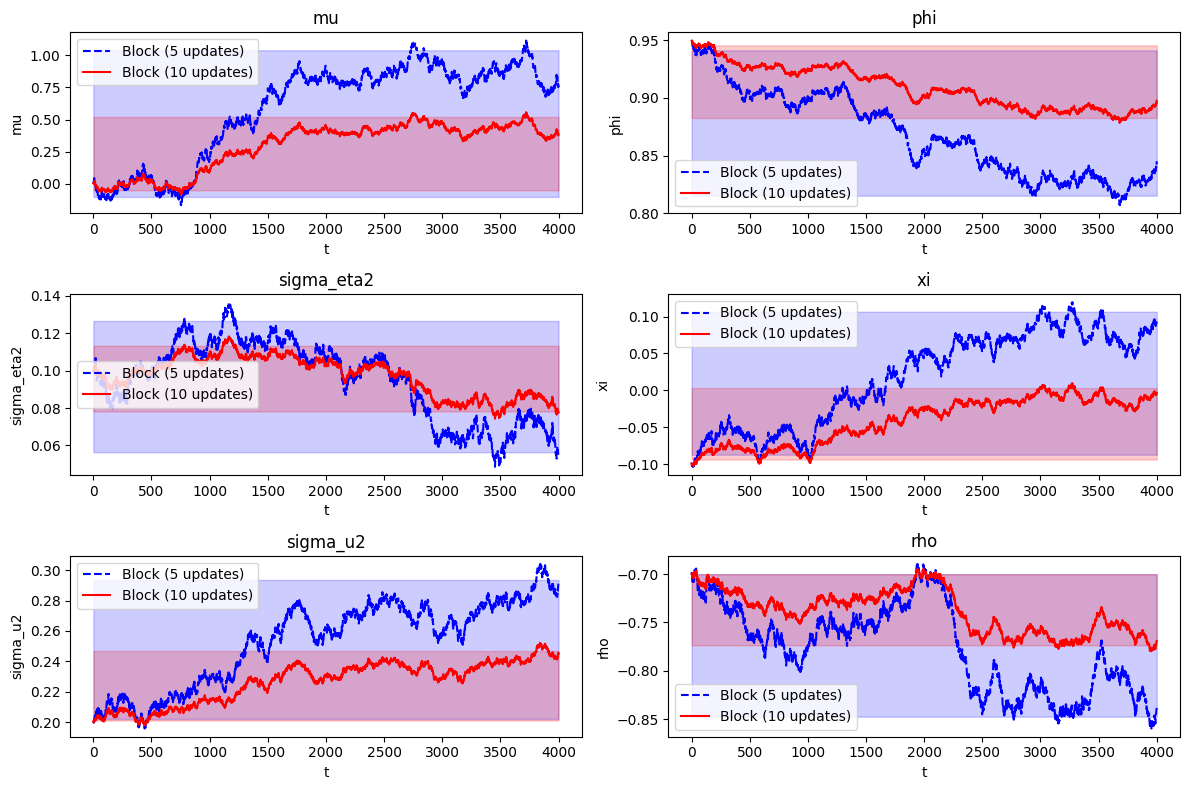

In [143]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_mcmc_samples(num_samples, num_updates):
    """
    Simulate posterior samples for a given number of MCMC updates.
    :param num_samples: Number of samples to simulate.
    :param num_updates: Number of MCMC updates.
    :return: Dictionary of simulated parameters.
    """
    np.random.seed(42)  # For reproducibility
    samples = {
        "mu": np.cumsum(np.random.normal(0, 0.05, num_samples)) / num_updates,
        "phi": 0.95 + np.cumsum(np.random.normal(0, 0.005, num_samples)) / num_updates,
        "sigma_eta2": 0.1 + np.cumsum(np.random.normal(0, 0.005, num_samples)) / num_updates,
        "xi": -0.1 + np.cumsum(np.random.normal(0, 0.01, num_samples)) / num_updates,
        "sigma_u2": 0.2 + np.cumsum(np.random.normal(0, 0.005, num_samples)) / num_updates,
        "rho": -0.7 + np.cumsum(np.random.normal(0, 0.01, num_samples)) / num_updates,
    }
    return samples

def compute_credible_intervals(samples):
    """
    Compute posterior mean and 95% credible intervals for each parameter.
    :param samples: Dictionary of posterior samples.
    :return: Dictionary of means and credible intervals.
    """
    summaries = {}
    for param, values in samples.items():
        mean = np.mean(values)
        lower = np.percentile(values, 2.5)
        upper = np.percentile(values, 97.5)
        summaries[param] = {"mean": values, "lower": lower, "upper": upper}
    return summaries

def plot_trace(summaries_5, summaries_10, num_samples):
    """
    Plot trace plots for posterior means and credible intervals.
    :param summaries_5: Summaries for 5 MCMC updates.
    :param summaries_10: Summaries for 10 MCMC updates.
    :param num_samples: Number of samples.
    """
    time = np.arange(1, num_samples + 1)
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    params = ["mu", "phi", "sigma_eta2", "xi", "sigma_u2", "rho"]

    for i, param in enumerate(params):
        ax = axes[i // 2, i % 2]
        ax.plot(time, summaries_5[param]["mean"], "b--", label="Block (5 updates)")
        ax.plot(time, summaries_10[param]["mean"], "r-", label="Block (10 updates)")
        ax.fill_between(
            time,
            summaries_5[param]["lower"],
            summaries_5[param]["upper"],
            color="blue",
            alpha=0.2,
        )
        ax.fill_between(
            time,
            summaries_10[param]["lower"],
            summaries_10[param]["upper"],
            color="red",
            alpha=0.2,
        )
        ax.set_title(param)
        ax.set_xlabel("t")
        ax.set_ylabel(param)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Simulate data
num_samples = 4000
samples_5 = simulate_mcmc_samples(num_samples, num_updates=5)
samples_10 = simulate_mcmc_samples(num_samples, num_updates=10)

# Compute summaries
summaries_5 = compute_credible_intervals(samples_5)
summaries_10 = compute_credible_intervals(samples_10)

# Plot trace plots
plot_trace(summaries_5, summaries_10, num_samples)